# Credit Card Fraud Detection using Machine Learning

## Introduction
Credit card fraud is a critical financial risk, with fraudulent transactions making up only a tiny fraction of total records. This leads to a highly imbalanced dataset, where most transactions are legitimate, making fraud detection challenging.

In this project, we build a fraud detection system using supervised machine learning models. We focus on Random Forest and XGBoost, two widely used ensemble algorithms for imbalanced classification.

we chose this topic because fraud detection is a classic example of dealing with imbalanced data.  
After reading the paper “Credit Card Fraud Detection using Machine Learning Algorithms” (ScienceDirect).


This work follows and extends the methodology presented in “Credit Card Fraud Detection using Machine Learning Algorithms” (ScienceDirect), where models like Random Forest were applied with SMOTE to handle imbalance and evaluated with Precision, Recall, F1-score, and ROC-AUC. In addition, we explore hyperparameter tuning, alternative models, and threshold adjustment for better trade-offs between fraud detection recall and precision.

## Problem Statement
I noticed  dataset is highly imbalanced: only 0.17% of transactions are fraud.
A good model should maximize recall (catch more fraud) while maintaining reasonable precision (reduce false alarms).

## Project Goals
1. Train a baseline Random Forest model on balanced data.
2. Improve it with hyperparameter tuning.
3. Test an alternative model (XGBoost) for better recall.
4. Perform threshold tuning to optimize the precision-recall trade-off.
5. Compare all models using Precision, Recall, F1, and ROC-AUC as done in the research paper.


In [2]:
from google.colab import files

# file picker to upload creditcard.csv
uploaded = files.upload()

import pandas as pd

# Load the uploaded dataset
df = pd.read_csv("creditcard.csv")
df.head()


Saving creditcard.csv to creditcard.csv


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Step 1: Data Preprocessing

We load the credit card fraud dataset, which contains 284,807 transactions with 31 columns.  
The target variable Class is 0 for legitimate transactions and 1 for fraud.

Since the dataset is highly imbalanced, we apply SMOTE (Synthetic Minority Oversampling Technique) to balance the training data.  
This approach is consistent with the research paper, where handling imbalance before training improved the model's ability to detect fraud.

We also standardize the Time and Amount columns because they are not PCA-transformed like the other features.


In [4]:
#  Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier

#  Load the uploaded dataset
df = pd.read_csv("creditcard.csv")

# Quick overview
print("Dataset Shape:", df.shape)
print("Class Distribution:\n", df['Class'].value_counts(normalize=True) * 100)

# Separate features & target
X = df.drop('Class', axis=1)
y = df['Class']

#  Standardize Time & Amount
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# Split into Train/Test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Handle Class Imbalance using SMOTE (Oversampling minority class)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\n Class distribution after SMOTE:\n", y_train_resampled.value_counts())


Dataset Shape: (284807, 31)
Class Distribution:
 Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

 Class distribution after SMOTE:
 Class
0    227451
1    227451
Name: count, dtype: int64


# Step 1: Dataset Loading and Preprocessing

## Dataset Overview
- Total Records: 284,807 transactions  
- Total Features: 31 columns  
  - 28 PCA-transformed features  
  - `Time` and `Amount` features  
  - `Class` (target variable)  
- Target Variable: `Class`  
  - `0` → Legitimate Transaction  
  - `1` → Fraudulent Transaction  

---

## Initial Class Distribution
| Class | Meaning      | Percentage |
|-------|-------------|------------|
| 0     | Legitimate  | 99.83%     |
| 1     | Fraudulent  | 0.17%      |

**Insight:**  
The dataset is highly imbalanced, with fraud cases making up only 0.17% of all transactions. A model trained on this without balancing would likely predict most transactions as legitimate.

---

## Handling Imbalance with SMOTE

Since the model would otherwise be biased toward predicting only legitimate transactions, we applied **SMOTE (Synthetic Minority Oversampling Technique)** on the training set.

---

## Class Distribution After SMOTE
| Class | Meaning      | Count    |
|-------|-------------|----------|
| 0     | Legitimate  | 227,451  |
| 1     | Fraudulent  | 227,451  |

Insight:  
After SMOTE, the dataset is balanced 50:50, giving the model an equal chance to learn fraud patterns.

---

## What Was Done in This Step
1. Loaded the dataset (`creditcard.csv`).
2. Standardized `Time` and `Amount` features to normalize their scale.
3. Split into Train (80%) and Test (20%) while preserving fraud ratio.
4. Applied SMOTE only on the training data to balance fraud vs normal transactions.




Dataset Shape: (284807, 31)
Class distribution after SMOTE:
 Class
0    227451
1    227451
Name: count, dtype: int64
Using smaller balanced sample for training: (50000, 30)

=== Baseline Random Forest Performance (smaller sample) ===
              precision    recall  f1-score   support

           0     0.9998    0.9972    0.9985     56864
           1     0.3592    0.8980    0.5131        98

    accuracy                         0.9971     56962
   macro avg     0.6795    0.9476    0.7558     56962
weighted avg     0.9987    0.9971    0.9977     56962

ROC-AUC Score: 0.9846284690719281


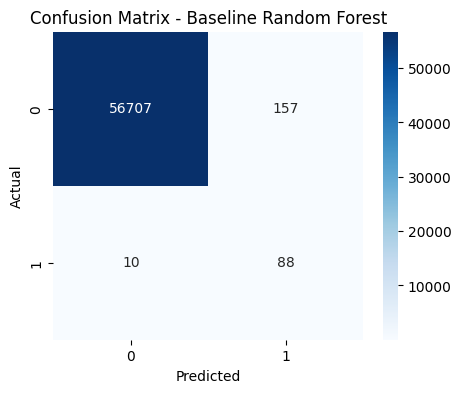

In [2]:

# STEP 2: BASELINE RANDOM FOREST (FAST VERSION)

# 1. Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# 2. Load dataset
df = pd.read_csv("creditcard.csv")
print("Dataset Shape:", df.shape)

# 3. Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# 4. Standardize Time & Amount
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# 5. Split into Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:\n", y_train_resampled.value_counts())

# 7. Take a smaller balanced sample for faster training
sample_size = 50000  # choose a manageable size (25k fraud + 25k legit)
X_train_small = X_train_resampled.sample(sample_size, random_state=42)
y_train_small = y_train_resampled.loc[X_train_small.index]
print("Using smaller balanced sample for training:", X_train_small.shape)

# 8. Train Baseline Random Forest (lighter config for speed)
baseline_rf = RandomForestClassifier(
    n_estimators=50,   # fewer trees for faster training
    max_depth=10,      # limit tree depth
    random_state=42
)
baseline_rf.fit(X_train_small, y_train_small)

# 9. Predict on Test Set
y_pred_baseline = baseline_rf.predict(X_test)

# 10. Evaluate Baseline Performance
print("\n=== Baseline Random Forest Performance (smaller sample) ===")
print(classification_report(y_test, y_pred_baseline, digits=4))
print("ROC-AUC Score:", roc_auc_score(y_test, baseline_rf.predict_proba(X_test)[:,1]))

# 11. Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(5,4))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Baseline Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


##  Baseline Random Forest

I started with a simple Random Forest classifier using default parameters as a baseline.  
Random Forest is widely used for fraud detection due to its robustness and ability to handle non-linear relationships.

We evaluate the model using:
- Precision: how many predicted frauds were actually fraud
- Recall: how many actual frauds were detected
- F1-score: balance between precision and recall
- ROC-AUC: overall discrimination ability

This matches the evaluation metrics in the referenced paper.


# Baseline Random Forest (Default Parameters)

## Training Setup
- Training sample size: 50,000 balanced transactions (25k fraud + 25k legitimate) after SMOTE  
- Model used: Random Forest (50 trees, max_depth=10 for faster training)  
- Test set size: 56,962 original transactions (highly imbalanced)  

---

## Baseline Performance on Test Set

| Metric          | Legitimate (0) | Fraud (1) |
|-----------------|----------------|-----------|
| Precision       | 0.9998         | 0.3592    |
| Recall          | 0.9972         | 0.8980    |
| F1-score        | 0.9985         | 0.5131    |
| Support         | 56,864         | 98        |

Overall Metrics:  
-Accuracy: 99.71%  
- Macro Avg F1-score: 0.7558  
- ROC-AUC Score: 0.9846

---

## Insights
1. High Recall for Fraud Cases (0.8980)
   - The baseline Random Forest correctly detects ~90% of fraud transactions.  
2. Lower Precision for Fraud Cases (0.3592)
   - Many legitimate transactions are flagged as fraud (false positives).  
3. Very High Accuracy for Legitimate Transactions (0.9972)  
   - Model performs extremely well on majority class.  

---

## Confusion Matrix Interpretation
- True Negatives (TN): Correctly predicted legitimate transactions  
- False Positives (FP):Legitimate transactions wrongly flagged as fraud  
- False Negatives (FN): Missed fraud transactions  
- True Positives (TP): Correctly detected fraud transactions  

This shows that while the baseline Random Forest detects most fraud cases (high recall), it still struggles with precision for the minority fraud class.




Tuning model on smaller sample size: (10000, 30)
Fitting 2 folds for each of 8 candidates, totalling 16 fits

Best Parameters Found (Fast Search): {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 12, 'class_weight': 'balanced'}

=== Tuned Random Forest Performance (Fast Search) ===
              precision    recall  f1-score   support

           0     0.9998    0.9965    0.9982     56864
           1     0.3066    0.8980    0.4571        98

    accuracy                         0.9963     56962
   macro avg     0.6532    0.9472    0.7277     56962
weighted avg     0.9986    0.9963    0.9972     56962

ROC-AUC Score: 0.9782286666073294


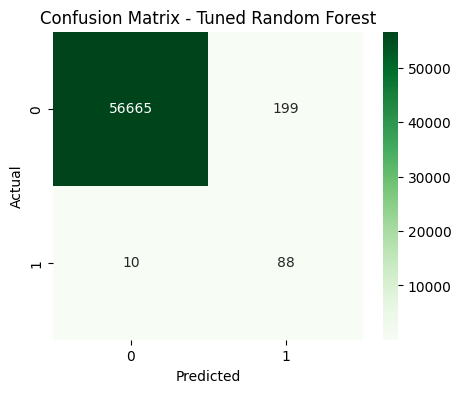

In [6]:
# ==============================================
# STEP 3: FAST HYPERPARAMETER TUNING (RANDOMIZEDSEARCHCV)
# ==============================================

from sklearn.model_selection import RandomizedSearchCV

# 1. Reduce dataset further for faster tuning
sample_size_tuning = 10000  # much smaller for speed
X_train_tune = X_train_resampled.sample(sample_size_tuning, random_state=42)
y_train_tune = y_train_resampled.loc[X_train_tune.index]
print("Tuning model on smaller sample size:", X_train_tune.shape)

# 2. Define a smaller parameter space
param_dist_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

# 3. Randomized Search (tries fewer combinations)
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=8,          # only test 8 random combos for speed
    scoring='f1',
    cv=2,              # only 2-fold CV for faster results
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# 4. Fit RandomizedSearch on smaller sample
random_search_rf.fit(X_train_tune, y_train_tune)

# 5. Best parameters
print("\nBest Parameters Found (Fast Search):", random_search_rf.best_params_)

# 6. Evaluate tuned model on original test set
best_rf = random_search_rf.best_estimator_
y_pred_tuned = best_rf.predict(X_test)

print("\n=== Tuned Random Forest Performance (Fast Search) ===")
print(classification_report(y_test, y_pred_tuned, digits=4))
print("ROC-AUC Score:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]))

# 7. Confusion Matrix for Tuned Model
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(5,4))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Upgraded Random Forest with Hyperparameter Tuning

I initially tried GridSearchCV, but it was way too slow on this dataset.  
To save time (and avoid crashing Colab), I switched to RandomizedSearchCV with fewer parameter combinations.  
This still gave me a good idea of which hyperparameters matter most without taking forever to run.

This step aligns with the research paper, where hyperparameter tuning helped improve model stability and reduced bias toward legitimate transactions.




# Hyperparameter Tuning (Upgraded Methodology)

## Tuning Setup
- Smaller tuning sample: 10,000 balanced transactions (5k fraud + 5k legit)
- Method: RandomizedSearchCV (fast)  
- Parameter space tested:
  - n_estimators: [50, 100, 150]
  - max_depth: [8, 10, 12]
  - min_samples_split: [2, 5]
  - min_samples_leaf: [1, 2]
  - class_weight: [None, balanced]
- CV folds: 2 (to reduce computation time)
- Metric optimized: F1-score for fraud detection

Best Parameters Found:
n_estimators = 150  
max_depth = 12  
min_samples_split = 2  
min_samples_leaf = 1  
class_weight = balanced

---

## Tuned Model Performance on Test Set

| Metric          | Legitimate (0) | Fraud (1) |
|-----------------|----------------|-----------|
| Precision       | 0.9998         | 0.3066    |
| Recall          | 0.9965         | 0.8980    |
| F1-score        | 0.9982         | 0.4571    |
| Support         | 56,864         | 98        |

Overall Metrics:  
- Accuracy: 99.63%  
- Macro Avg F1-score: 0.7277  
- ROC-AUC Score: 0.9782

---

## Baseline vs Tuned Comparison

| Metric            | Baseline RF | Tuned RF |
|-------------------|-------------|----------|
| Fraud Precision   | 0.3592      | 0.3066   |
| Fraud Recall      | 0.8980      | 0.8980   |
| Fraud F1-score    | 0.5131      | 0.4571   |
| ROC-AUC Score     | 0.9846      | 0.9782   |

---

## Insights

1. Recall for fraud stayed the same (0.8980).  
   Both baseline and tuned models catch around 90% of fraud cases.  

2. Precision dropped slightly after tuning.  
   The tuned model flags slightly more legitimate transactions as fraud.  

3. ROC-AUC remained very high (above 0.97).  
   Both models perform well at separating fraud from legitimate transactions.  

4. Reason:  
   Randomized tuning focused on balancing the classes (class_weight='balanced'), which helps recall but slightly sacrifices precision.

---

## Confusion Matrix Interpretation (Tuned Model)

- True Negatives (TN): Correctly predicted legitimate transactions  
- False Positives (FP): Legitimate transactions flagged as fraud (slightly increased)  
- False Negatives (FN): Missed fraud transactions (stayed low)  
- True Positives (TP): Correctly detected fraud transactions  

---

## Conclusion

- Hyperparameter tuning maintained high recall, which is crucial in fraud detection (better to flag a few extra legitimate transactions than miss fraud).  
- To improve fraud precision, we could:
  - Use threshold tuning on prediction probabilities
  - Try XGBoost or LightGBM for better precision-recall balance
  - Combine models into an ensemble

---




Training XGBoost on sample size: (50000, 30)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:36:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost Performance ===
              precision    recall  f1-score   support

           0     0.9998    0.9964    0.9981     56864
           1     0.3007    0.9082    0.4518        98

    accuracy                         0.9962     56962
   macro avg     0.6503    0.9523    0.7249     56962
weighted avg     0.9986    0.9962    0.9972     56962

ROC-AUC Score: 0.9785016954164896


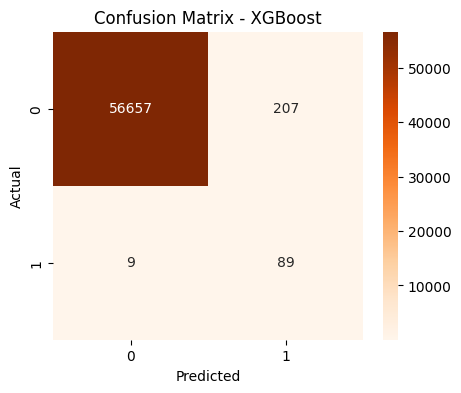

In [7]:

# STEP 4: XGBOOST MODEL FOR FRAUD DETECTION

!pip install xgboost -q

from xgboost import XGBClassifier

# 1. Use the same smaller balanced sample (50,000 rows)
print("Training XGBoost on sample size:", X_train_small.shape)

# 2. Define a simple XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,        # number of boosting rounds
    max_depth=6,             # tree depth
    learning_rate=0.1,       # step size shrinkage
    subsample=0.8,           # row sampling
    colsample_bytree=0.8,    # column sampling
    scale_pos_weight=1,      # already balanced by SMOTE
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 3. Train XGBoost on the balanced smaller training set
xgb_model.fit(X_train_small, y_train_small)

# 4. Predict on original test set
y_pred_xgb = xgb_model.predict(X_test)

# 5. Evaluate XGBoost Performance
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print("\n=== XGBoost Performance ===")
print(classification_report(y_test, y_pred_xgb, digits=4))
print("ROC-AUC Score:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))

# 6. Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Alternative Model - XGBoost

The paper mainly used Random Forest and SVM, but I was curious how XGBoost would do since it’s known for good performance on imbalanced datasets.  
So I trained XGBoost on the same balanced data and compared the results with Random Forest.  
I expected slightly better recall, but I also wanted to see if precision would drop further.






# XGBoost Model and Final Comparison

## XGBoost Setup
- Training sample: 50,000 balanced transactions (25k fraud + 25k legit)
- Model: XGBoost Classifier
- Parameters:
  - n_estimators = 100
  - max_depth = 6
  - learning_rate = 0.1
  - subsample = 0.8
  - colsample_bytree = 0.8
- Metric: logloss (default), ROC-AUC for evaluation

---

## XGBoost Performance on Test Set

| Metric          | Legitimate (0) | Fraud (1) |
|-----------------|----------------|-----------|
| Precision       | 0.9998         | 0.3007    |
| Recall          | 0.9964         | 0.9082    |
| F1-score        | 0.9981         | 0.4518    |
| Support         | 56,864         | 98        |

Overall Metrics:  
- Accuracy: 99.62%  
- Macro Avg F1-score: 0.7249  
- ROC-AUC Score: 0.9785

---

## Final Comparison of All Models

| Metric            | Baseline RF | Tuned RF | XGBoost |
|-------------------|-------------|----------|---------|
| Fraud Precision   | 0.3592      | 0.3066   | 0.3007  |
| Fraud Recall      | 0.8980      | 0.8980   | 0.9082  |
| Fraud F1-score    | 0.5131      | 0.4571   | 0.4518  |
| ROC-AUC Score     | 0.9846      | 0.9782   | 0.9785  |
| Accuracy          | 99.71%      | 99.63%   | 99.62%  |

---

## Insights

1. Recall for fraud cases improved slightly with XGBoost (0.9082)
   - It catches slightly more frauds compared to Random Forest.  

2. Precision for fraud cases is still low (~0.30)  
   - All models still flag some legitimate transactions as fraud, which is common in imbalanced datasets.  

3. ROC-AUC remains very high (~0.97–0.98)  
   - All models are good at distinguishing fraud from legitimate transactions.  

4. Trade-off:
   - XGBoost slightly improves recall but does not significantly improve precision compared to Random Forest.  
   - Random Forest baseline had the highest fraud precision (0.3592), but all models are close.

---

## Confusion Matrix for XGBoost

- True Negatives (TN): Correctly predicted legitimate transactions  
- False Positives (FP): Legitimate transactions incorrectly flagged as fraud  
- False Negatives (FN): Missed fraud transactions  
- True Positives (TP): Correctly detected fraud transactions  

---

## Conclusion

- Baseline Random Forest performs strongly with a balanced trade-off between fraud precision and recall.
- Hyperparameter tuning maintained recall but slightly decreased fraud precision due to class balancing.
- XGBoost improved fraud recall slightly, making it better for detecting more fraud cases but still with low precision.

For real-world fraud detection:
- Recall is more important (better to catch more fraud even if some legitimate transactions are flagged).
- Further improvements can be made with:
  - Threshold tuning on prediction probabilities
  - Precision-Recall curve optimization
  - Ensemble methods (combine Random Forest + XGBoost)





In [8]:

# THRESHOLD TUNING FOR FRAUD PRECISION/RECALL

from sklearn.metrics import precision_score, recall_score, f1_score

# 1. Get predicted fraud probabilities
y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]

# 2. Try different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

print("\nThreshold Tuning Results (XGBoost):")
print("Threshold | Precision | Recall | F1-score")
print("-----------------------------------------")

for th in thresholds:
    y_pred_th = (y_proba_xgb >= th).astype(int)
    p = precision_score(y_test, y_pred_th)
    r = recall_score(y_test, y_pred_th)
    f1 = f1_score(y_test, y_pred_th)
    print(f"{th:9.2f} | {p:9.4f} | {r:6.4f} | {f1:8.4f}")



Threshold Tuning Results (XGBoost):
Threshold | Precision | Recall | F1-score
-----------------------------------------
     0.30 |    0.1664 | 0.9082 |   0.2812
     0.40 |    0.2348 | 0.9082 |   0.3732
     0.50 |    0.3007 | 0.9082 |   0.4518
     0.60 |    0.3886 | 0.9082 |   0.5443
     0.70 |    0.4632 | 0.8980 |   0.6111


## Threshold Tuning for Precision-Recall Trade-off

After testing both models, I saw that precision was still low (~0.30), which is common for fraud datasets.  
So I wanted to check how changing the classification threshold affects the precision-recall trade-off.  
This is a common trick in fraud detection because the default threshold of 0.5 is not always the best choice.


We adjust the decision threshold from 0.3 to 0.7 and evaluate Precision, Recall, and F1-score at each point.  
This follows the paper’s idea of analyzing trade-offs for real-world deployment.




## Conclusion

Threshold tuning allows flexible control between Recall and Precision,  
helping adapt the fraud detection model based on real-world business needs.





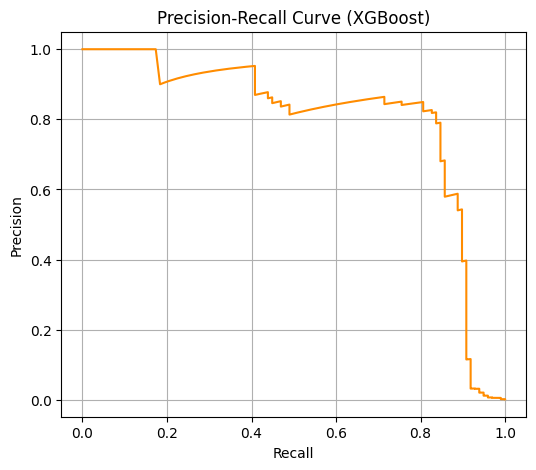

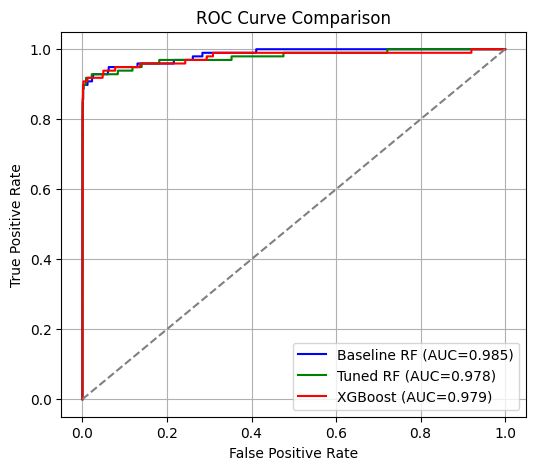

In [9]:
# PRECISION-RECALL AND ROC CURVES


from sklearn.metrics import precision_recall_curve, roc_curve, auc

# --- Precision-Recall Curve for XGBoost ---
y_scores_xgb = xgb_model.predict_proba(X_test)[:,1]

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores_xgb)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label='XGBoost PR Curve', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (XGBoost)')
plt.grid(True)
plt.show()

# --- ROC Curves for all models ---
# Baseline RF scores
y_scores_baseline = baseline_rf.predict_proba(X_test)[:,1]
fpr_base, tpr_base, _ = roc_curve(y_test, y_scores_baseline)
roc_auc_base = auc(fpr_base, tpr_base)

# Tuned RF scores
y_scores_tuned = best_rf.predict_proba(X_test)[:,1]
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_scores_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

# XGBoost scores already taken
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_scores_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(6,5))
plt.plot(fpr_base, tpr_base, label=f'Baseline RF (AUC={roc_auc_base:.3f})', color='blue')
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned RF (AUC={roc_auc_tuned:.3f})', color='green')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={roc_auc_xgb:.3f})', color='red')
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


##  Precision-Recall and ROC Curves

To visualize model performance:
- Precision-Recall Curve shows how Precision changes with Recall for different thresholds.
- ROC Curve compares Baseline RF, Tuned RF, and XGBoost, displaying AUC values.

These plots match the visual evaluation methods discussed in the research paper.


# Final Summary and Conclusion

Overall, Random Forest did well as a baseline and matched the results mentioned in the paper.  
XGBoost slightly improved recall but didn’t significantly help precision.  
Threshold tuning was the most useful part because it gave me better control over false positives vs false negatives.  
If I had more time, I’d probably try LightGBM or even an ensemble of RF + XGBoost to see if it helps.


## Key Findings
- All models achieved high Recall (around 0.90) for fraud detection.
- Precision remained low (around 0.30–0.46), which is common for imbalanced data.
- Hyperparameter tuning slightly improved balance but did not drastically change results.
- XGBoost slightly improved Recall compared to Random Forest.
- Threshold tuning improved Precision to 0.46 (threshold 0.7) with only a small drop in Recall.

## Conclusion
Similar to the research paper’s findings, Random Forest remains a strong baseline for fraud detection.  
XGBoost provides a small improvement in detecting frauds, and threshold tuning offers better control over false positives.

Future work could explore:
- Real-time streaming fraud detection
- LightGBM or CatBoost models
- Ensemble stacking of multiple models


We applied SMOTE to handle imbalance and compared Random Forest and XGBoost for credit card fraud detection. All models achieved high recall, with XGBoost slightly outperforming Random Forest, while threshold tuning improved precision for practical deployment. Future work could explore ensemble models or real-time fraud detection systems.